# Классические методы машинного обучения

В этом ноутбуке мы анализируем задачу бинарной классификации с использованием классических моделей машинного обучения. Мы последовательно рассмотрим этапы предобработки, кодирования категориальных признаков, отбора признаков и построения моделей. 

Особое внимание будет уделено вопросу интерпретации и оценки качества моделей: мы проведем калибровку вероятностей, сравним модели по ROC-AUC, PR-AUC и по калибровочным кривым, а также сформулируем метрику бизнес-эффективности на основе прибыли.

# Часть 1. Базовая модель и оценка качества: SVM, логистическая регрессия 

Для построения и анализа моделей бинарной классификации мы сгенерируем синтетическое множество данных $(X, y)$ с помощью процедуры `make_classification`. Оно содержит $n = 10\,000$ объектов и $d = 10$ признаков, из которых 5 информативных и 5 — линейно зависимы от них. Полученные данные случайным образом разбиваются на обучающую и тестовую выборки в соотношении $70\% / 30\%$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=4
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Случайный классификатор

Введём базовую модель — случайный классификатор, не использующий признаки объектов. Его задача — выдавать случайные вероятности принадлежности объекта к положительному классу:
$$
f_{\text{rand}}: \mathbb{R}^d \to [0, 1],
$$
где $f_{\text{rand}}(x)$ выбирается равномерно случайно из $[0, 1]$, независимо от $x$.


In [2]:
from sklearn.dummy import DummyClassifier

random_classifier = DummyClassifier(strategy='uniform', random_state=43).fit(X_train, y_train)
y_random = random_classifier.predict(X_test)
y_random

array([0, 0, 1, ..., 1, 0, 1])

## Оценка качества: ROC и PR кривые

Для построения кривых и вычисления метрик используем следующие определения:

## Матрица ошибок бинарного классификатора

Рассмотрим схему бинарной классификации, в которой истинное значение отклика $y \in \{1, -1\}$, а алгоритм выдаёт решение $a(x) \in \{1, -1\}$. Матрица ошибок имеет следующий вид:

|                 | $y = 1$                   | $y = -1$                  |
|-----------------|---------------------------|---------------------------|
| $a(x) = 1$      | True Positive (TP)        | False Positive (FP)       |
| $a(x) = -1$     | False Negative (FN)       | True Negative (TN)        |

Обозначения:
- **TP** — количество объектов положительного класса, правильно классифицированных;
- **FP** — количество объектов отрицательного класса, ошибочно отнесённых к положительному;
- **FN** — положительные объекты, классифицированные как отрицательные;
- **TN** — отрицательные объекты, правильно классифицированные.


- **PR-кривая (Precision-Recall)**: отображает зависимость точности (precision) от полноты (recall), где
$$
\text{precision} = \frac{TP}{TP + FP}, \quad \text{recall} = \frac{TP}{TP + FN}.
$$

- **ROC-кривая (Receiver Operating Characteristic)**: отображает зависимость доли истинных положительных срабатываний (TPR) от доли ложных положительных (FPR),
$$
\text{TPR} = \frac{TP}{TP + FN}, \quad \text{FPR} = \frac{FP}{FP + TN}.
$$

Для визуализации качества модели построим:
- PR-кривую (precision-recall)
- ROC-кривую (receiver operating characteristic)

Площади под этими кривыми (AUC - area under curve) дают количественную оценку качества модели:
- AUC-PR лучше подходит при дисбалансе классов,
- AUC-ROC — более общая метрика качества ранжирования.

Random Classifier metrics
AUC-PR: 0.4995
AUC-ROC: 0.4957


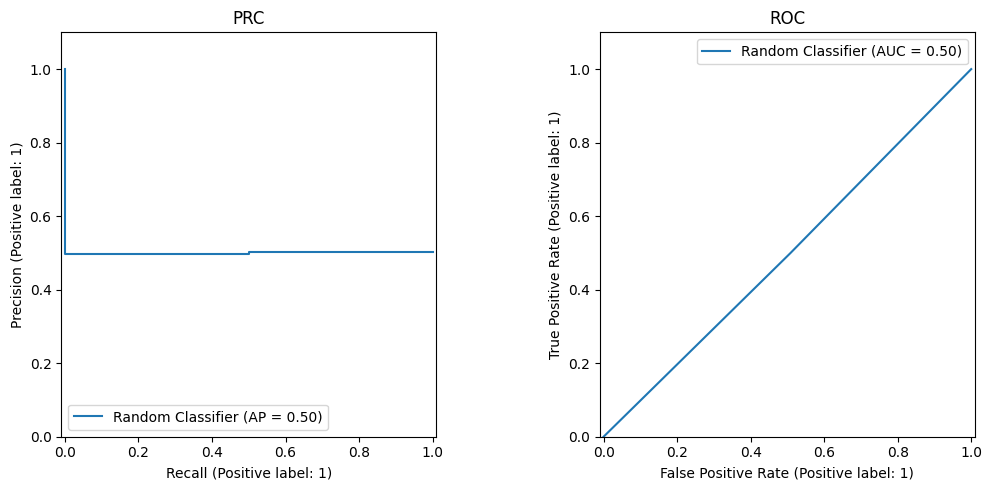

In [3]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()

depict_pr_roc(y_test, y_random, 'Random Classifier')

## Табличное сравнение моделей по метрикам качества

Для удобства сравнения различных алгоритмов классификации мы заведём таблицу, содержащую следующие количественные показатели:

- $ \text{AUC-PR} $ 
- $ \text{AUC-ROC} $
- $ \lambda $ — параметр регуляризации (если применимо).

Каждой модели будет соответствовать одна строка в таблице. Начнём с фиксации характеристик случайного классификатора.


In [4]:
df_metrics = pd.DataFrame(columns=['auc_pr', 'roc_auc_score', 'reg_const'])

precision, recall, _ = precision_recall_curve(y_test, y_random)

df_metrics.loc['Random Classifier'] = [
    average_precision_score(y_test, y_random),
    roc_auc_score(y_test, y_random),
    0,
]
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.499512,0.495653,0.0


## Support Vector Machine (linear kernel)

Метод опорных векторов с линейным ядром представляет собой задачу оптимизации следующего вида:
$$
\min_{w, b} \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{n} \max(0, 1 - y_i (w^\top x_i + b)),
$$
где $C > 0$ — параметр регуляризации, контролирующий компромисс между шириной зазора и штрафом за ошибочную классификацию.

Наша цель — подобрать параметр $C$ с точки зрения максимизации площади под PR-кривой (AUC-PR). Для этого мы проведём перебор по значениям $C$ и выберем то, которое даёт наилучший результат по AUC-PR на валидационной выборке.


In [5]:
X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=1)

In [6]:
from sklearn.svm import SVC

C_values = np.logspace(-3, 2, 10)
scores = []

for C in C_values:
    clf = SVC(C=C, kernel='linear', probability=True, random_state=0)
    clf.fit(X_subtrain, y_subtrain)
    y_val_pred = clf.predict_proba(X_val)[:, 1]
    auc_pr = average_precision_score(y_val, y_val_pred)
    scores.append(auc_pr)

best_C = C_values[np.argmax(scores)]

SVM (C=0.167) metrics
AUC-PR: 0.9722
AUC-ROC: 0.9656


,auc_pr,roc_auc_score,reg_const
Random Classifier,0.499512,0.495653,0.00000
SVM (C=0.167),0.972177,0.965649,0.16681


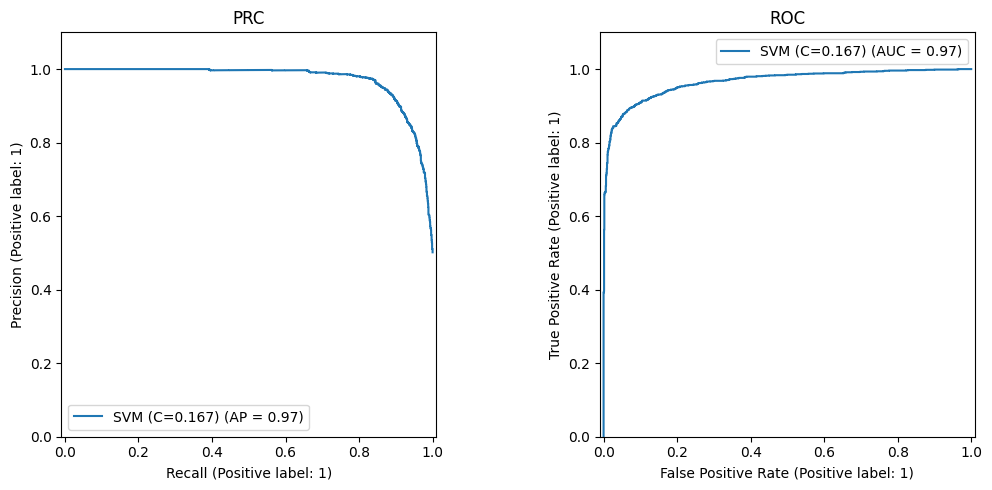

In [7]:
svm_clf = SVC(C=best_C, kernel='linear', probability=True, random_state=0)
svm_clf.fit(X_train, y_train)
y_svm = svm_clf.predict_proba(X_test)[:, 1]

depict_pr_roc(y_test, y_svm, classifier_name=f'SVM (C={best_C:.3g})')

df_metrics.loc[f'SVM (C={best_C:.3g})'] = [
    average_precision_score(y_test, y_svm),
    roc_auc_score(y_test, y_svm),
    best_C,
]

df_metrics

## Логистическая регрессия с $L_2$-регуляризацией

Рассмотрим логистическую регрессию с $L_2$-регуляризатором. Параметры модели $(w, b)$ находятся из задачи:
$$
\min_{w, b} \; \frac{1}{n} \sum_{i=1}^n \log\left(1 + \exp(-y_i (w^\top x_i + b)) \right) + \frac{\lambda}{2} \|w\|^2,
$$
где $ \lambda = \frac{1}{C} > 0 $ — коэффициент регуляризации, а $C$ — его обратная величина, контролирующая степень сглаживания.

Наша цель — подобрать оптимальное значение $C$ по валидационной выборке, используя метрику $ \text{AUC-PR} $. Получившуюся модель мы протестируем на тестовых данных, построим ROC и PR кривые, а также сравним её характеристики с предыдущими моделями.


In [8]:
from sklearn.linear_model import LogisticRegression
scores = []

for C in C_values:
    clf = LogisticRegression(C=C, penalty='l2', solver='liblinear', random_state=0)
    clf.fit(X_subtrain, y_subtrain)
    y_val_pred = clf.predict_proba(X_val)[:, 1]
    auc_pr = average_precision_score(y_val, y_val_pred)
    scores.append(auc_pr)

best_C = C_values[np.argmax(scores)]

LogReg (C=0.0464) metrics
AUC-PR: 0.9722
AUC-ROC: 0.9661


,auc_pr,roc_auc_score,reg_const
Random Classifier,0.499512,0.495653,0.000000
SVM (C=0.167),0.972177,0.965649,0.166810
LogReg (C=0.0464),0.972228,0.966098,0.046416


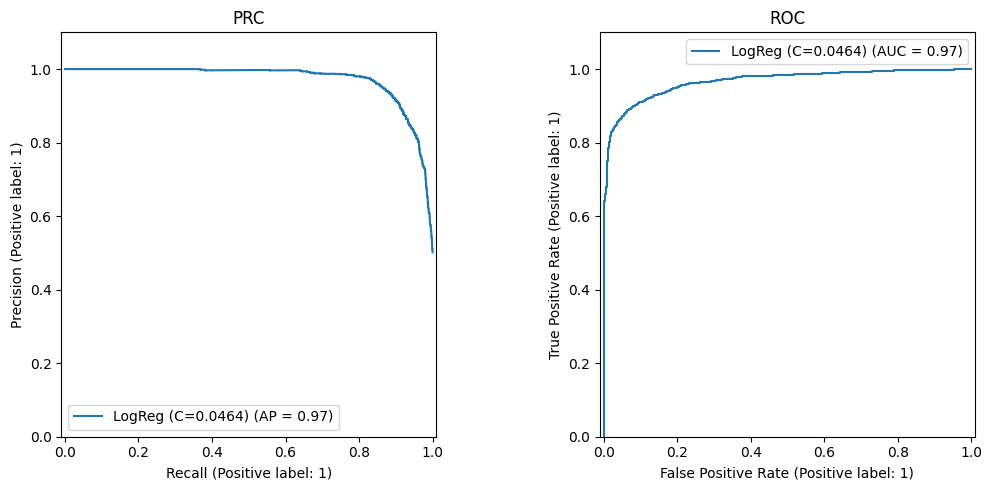

In [9]:
logreg = LogisticRegression(C=best_C, penalty='l2', solver='liblinear', random_state=0)
logreg.fit(X_train, y_train)
y_logreg = logreg.predict_proba(X_test)[:, 1]

depict_pr_roc(y_test, y_logreg, classifier_name=f'LogReg (C={best_C:.3g})')

df_metrics.loc[f'LogReg (C={best_C:.3g})'] = [
    average_precision_score(y_test, y_logreg),
    roc_auc_score(y_test, y_logreg),
    best_C,
]

df_metrics

# Часть 2. Обработка категориальных переменных

Категориальные признаки требуют особого обращения: они не обладают естественным порядком, поэтому нельзя кодировать их числами напрямую. Присвоение значений $\{1, 2, \dots, m\}$ категории $C = \{c_1, \dots, c_m\}$ создаёт искусственный линейный порядок, который может ввести модель в заблуждение.

В данной части мы рассмотрим два подхода:

- **One-hot кодирование**: каждое значение категории превращается в отдельный бинарный признак.
- **Счётчики**: значение категориального признака заменяется на среднее значение целевой переменной по объектам с такой категорией.

## One-hot кодирование

Пусть категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков:
$$
b_i(x) = [f_j(x) = c_i], \quad i = 1, \dots, m,
$$


## Подготовка данных

В качестве эксперимента мы рассмотрим датасет "Bike Buyers", содержащий сведения о клиентах и информацию о том, купили ли они велосипед. Наша задача — предсказать бинарную целевую переменную.

Шаги подготовки:
- заменим пропущенные значения в категориальных признаках на категорию `'undefined'`;
- разобьём признаки на два подмножества: числовые и категориальные.


In [10]:
import pandas as pd
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

df = pd.read_csv(path)

In [11]:
df['Purchased Bike'] = df['Purchased Bike'].apply(lambda x: 1 if (x == "Yes") else 0)
y = df['Purchased Bike'].copy()
df.drop(columns=['Purchased Bike'], inplace=True)

In [12]:
categorical_columns = df.select_dtypes(include='object').columns
numerical_columns = df.select_dtypes(include='number').columns

df[categorical_columns] = df[categorical_columns].fillna('undefined')
df[numerical_columns] = df[numerical_columns].fillna(-1)
df_cat = df[categorical_columns]
df_num = df[numerical_columns]

## Работа с категориальными признаками

На данном этапе мы сосредоточимся исключительно на категориальных переменных. Разобьём выборку на обучающую и тестовую части, сохранив пропорцию классов (стратифицированная разбивка).


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    df_cat, y, 
    test_size=0.25, 
    random_state=777, 
    stratify=y
)

#### Ordinal Encoding категориальных признаков

Рассмотрим подход, при котором категориальные признаки переводятся в целые числа при помощи кодировщика `OrdinalEncoder`. Пусть $f_j(x)$ — категориальный признак, принимающий значения из множества $C_j = \{c_1, \dots, c_m\}$. Тогда каждому $c_k \in C_j$ сопоставляется уникальное число $k - 1$.

Отметим, что такой подход задаёт порядок на множестве $C_j$, который не несёт смысла и может искажать поведение модели. Тем не менее, исследуем, как он повлияет на метрику AUC-PR при использовании логистической регрессии.

Также измерим время, затраченное на кодирование и обучение модели.


Время кодирования и обучения: 0.02 сек
Log regression with Ordinal encoder metrics
AUC-PR: 0.5887
AUC-ROC: 0.5926


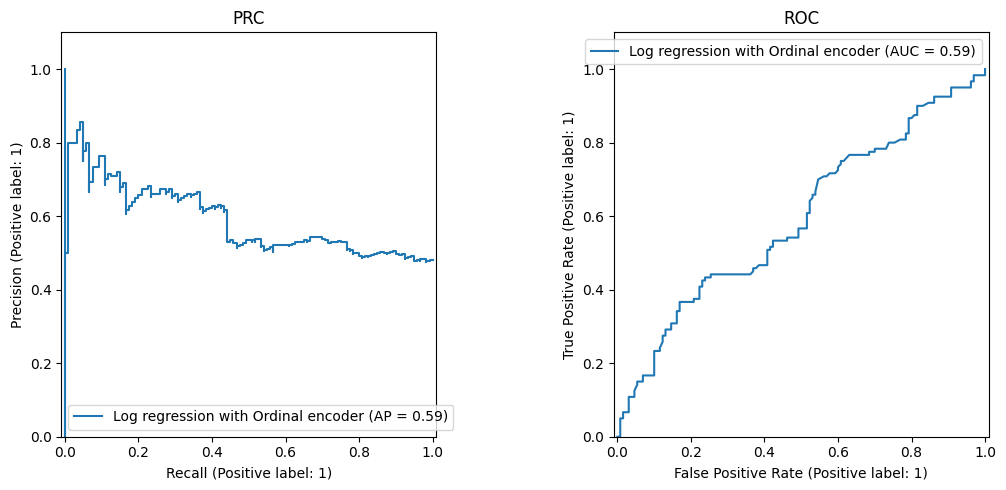

In [14]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import average_precision_score
from time import time

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

column_transformer = ColumnTransformer([
    ('ordinal_encoder', encoder, categorical_columns)
])

pipeline = Pipeline(steps=[
    ('col_trans', column_transformer),
    ('classifier', LogisticRegression(penalty='l2', max_iter=1000))
])

start = time()

model = pipeline.fit(X_train, y_train)
duration = time() - start
y_pred = model.predict_proba(X_test)[:, 1]

print("Время кодирования и обучения: %.2f сек" % duration)
depict_pr_roc(y_test, y_pred, 'Log regression with Ordinal encoder')

Мы произведём one-hot-кодирование обучающей и тестовой выборок, обучим логистическую регрессию на новых признаках, и сравним результат с предыдущим способом кодирования по метрике AUC-PR. Также измерим общее время кодирования и обучения.


Время кодирования и обучения: 0.02 сек
Log regression with OneHotEncoder metrics
AUC-PR: 0.6663
AUC-ROC: 0.6796


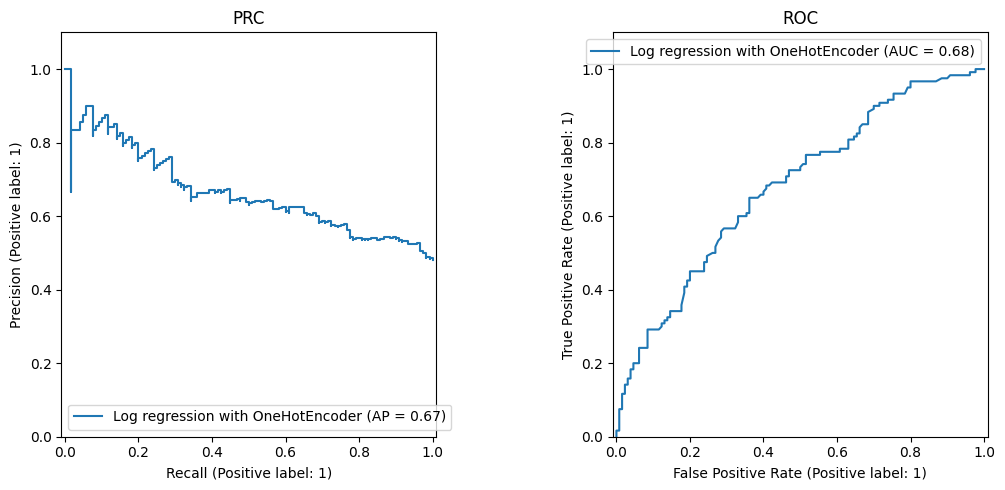

In [15]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore')

column_transformer = ColumnTransformer([
    ('ordinal_encoder', encoder, categorical_columns)
])

pipeline = Pipeline(steps=[
    ('col_trans', column_transformer),
    ('classifier', LogisticRegression(penalty='l2', max_iter=1000))
])

start = time()

model = pipeline.fit(X_train, y_train)
duration_ = time() - start
y_pred = model.predict_proba(X_test)[:, 1]

print("Время кодирования и обучения: %.2f сек" % duration)
depict_pr_roc(y_test, y_pred, 'Log regression with OneHotEncoder')

#### Сравнение подходов Ordinal Encoding и One-Hot Encoding

Сравнив два способа обработки категориальных признаков — порядковое кодирование и one-hot-кодирование — мы пришли к следующему выводу: наблюдается, что `OrdinalEncoder` имеет хуже качество чем `OneHotEncoder` что указывает на превосходство one-hot-кодирования в данном контексте.

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.

#### Счётчики (Mean-Target Encoding)

Рассмотрим альтернативный способ кодирования категориальных признаков, известный как счётчики (mean-target encoding).

Пусть $x \in \mathcal{X}$ — произвольный объект, $f_j(x)$ — значение $j$-го категориального признака, и $y_i \in \{0, 1\}$ — целевая переменная.

Мы определим новую числовую функцию $g_j(x, X)$ следующим образом:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] \cdot [y_i = 1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]},
$$
то есть каждое категориальное значение заменяется на среднее значение целевой переменной по всем объектам, обладающим тем же значением в данном признаке.

Этот способ существенно сокращает размерность признакового пространства по сравнению с one-hot-кодированием, что положительно сказывается на скорости работы модели.

In [16]:
def mean_target_encoding(X_train, y_train, X_test):
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()

    for col in X_train.columns:
        means = y_train.groupby(X_train[col]).mean()
        X_train_encoded[col] = X_train[col].map(means)
        X_test_encoded[col] = X_test[col].map(means)

        overall_mean = y_train.mean()
        X_test_encoded[col] = X_test_encoded[col].fillna(overall_mean)

    return X_train_encoded, X_test_encoded

Время кодирования и обучения: 0.02 сек
Log regression with Mean-Target Encoding metrics
AUC-PR: 0.6575
AUC-ROC: 0.6646


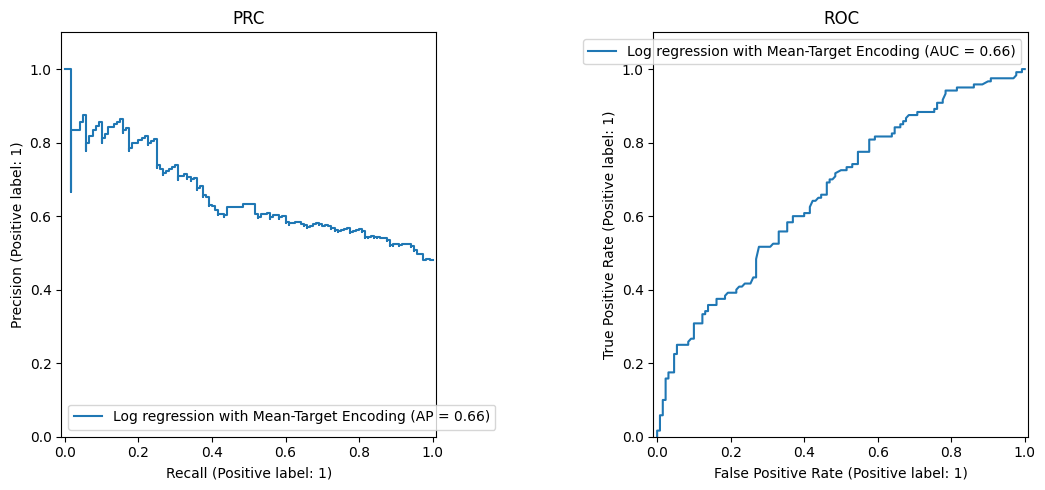

In [17]:
start = time()
X_train_ctr, X_test_ctr = mean_target_encoding(X_train, y_train, X_test)

model = LogisticRegression()
model.fit(X_train_ctr, y_train)
duration = time() - start
y_pred = model.predict_proba(X_test_ctr)[:, 1]

print("Время кодирования и обучения: %.2f сек" % duration)
depict_pr_roc(y_test, y_pred, 'Log regression with Mean-Target Encoding')

#### Сглаживание счётчиков

Для борьбы с переобучением категорий с малым количеством объектов используем сглаживание счётчиков:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = 1] + C \cdot \mu}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$

где $\mu$ — глобальная доля положительного класса, $C$ — коэффициент сглаживания. Чем больше $C$, тем сильнее влияние глобального среднего. Подберём $C$ по валидационной метрике AUC-PR, затем обучим модель на полном обучающем множестве.


#### Алгоритм поиска $C^*$

1. Разбиваем данные на обучающую и валидационную выборки
2. Для каждого кандидата $C \in \mathcal{C}$:
   - Вычисляем сглаженные средние на $X_{\text{subtrain}}$
   - Применяем кодирование к $X_{\text{val}}$
   - Оцениваем качество с помощью модели
3. Выбираем $C^*$ с наилучшим качеством на валидации

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoderOptimalC(BaseEstimator, TransformerMixin):
    """Кодировщик категориальных признаков с подбором оптимального C"""
    def __init__(self, columns, Cs=np.logspace(-5, 2, 20), random_state=42, val_size=0.3):
        self.columns = columns
        self.Cs = Cs
        self.random_state = random_state
        self.val_size = val_size
        self.best_C_ = None
        self.encoding_dict_ = {}
        self.global_mean_ = None
        
    def fit(self, X, y):
        X_subtrain, X_val, y_subtrain, y_val = train_test_split(
            X, y, 
            test_size=self.val_size, 
            random_state=self.random_state, 
            stratify=y
        )
        
        self.global_mean_ = y_subtrain.mean()
        best_score = -1
        best_C = None
        best_encodings = {}
        
        for C in self.Cs:
            current_encodings = {}
            X_subtrain_enc = X_subtrain[self.columns].copy()
            
            for col in self.columns:
                stats = pd.concat([
                    y_subtrain.groupby(X_subtrain[col]).sum(),
                    y_subtrain.groupby(X_subtrain[col]).count()
                ], axis=1).fillna(0)
                stats.columns = ['pos', 'cnt']
                stats['smooth'] = (stats['pos'] + C * self.global_mean_) / (stats['cnt'] + C)
                
                current_encodings[col] = stats['smooth'].to_dict()
                X_subtrain_enc[col] = X_subtrain[col].map(current_encodings[col]).fillna(self.global_mean_)
            
            X_val_enc = X_val[self.columns].copy()
            for col in self.columns:
                X_val_enc[col] = X_val[col].map(current_encodings[col]).fillna(self.global_mean_)
            
            model = LogisticRegression(max_iter=1000)
            model.fit(X_subtrain_enc, y_subtrain)
            preds = model.predict_proba(X_val_enc)[:, 1]
            score = average_precision_score(y_val, preds)
            
            if score > best_score:
                best_score = score
                best_C = C
                best_encodings = current_encodings
        
        self.best_C_ = best_C
        self.encoding_dict_ = best_encodings
        return self
    
    def transform(self, X):
        """Применяем найденное оптимальное кодирование"""
        X_enc = X[self.columns].copy()
        for col in self.columns:
            X_enc[col] = X_enc[col].map(self.encoding_dict_[col]).fillna(self.global_mean_)
        return X_enc

Best C: 1e-05
Some Classifier metrics
AUC-PR: 0.6429
AUC-ROC: 0.6527


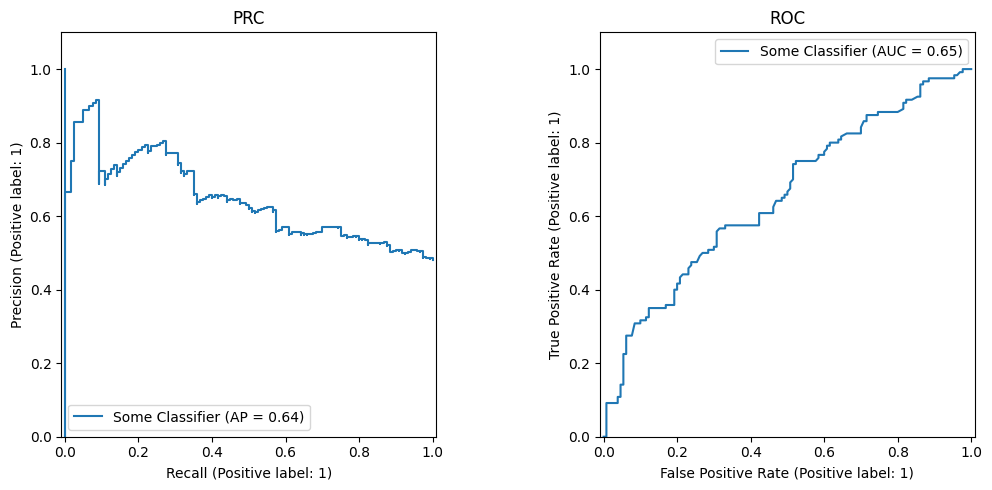

In [19]:
preprocessor = ColumnTransformer([
    ('cat', MeanTargetEncoderOptimalC(columns=categorical_columns, val_size=0.5), categorical_columns)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=5000))
]).fit(X_train, y_train)

best_C = pipeline.named_steps['preprocessor'].named_transformers_['cat'].best_C_
print(f'Best C: {best_C:}')

test_probs = pipeline.predict_proba(X_test)[:,1]
depict_pr_roc(y_test, test_probs)

## Наблюдение и анализ подбора константы сглаживания

### Ключевое наблюдение
В ходе экспериментов было установлено, что оптимальное значение константы сглаживания C стремится к нулю, далее будем считать $ С = 0 $. Это означает, что наилучшие результаты достигаются при использовании чистых групповых средних без дополнительного сглаживания.

### Возможные причины такого поведения

#### 1. Особенности распределения данных
- Категориальные признаки уже содержат достаточную статистическую информацию
- Групповые средние достаточно устойчивы и не требуют регуляризации
- Низкая дисперсия внутри категорий

#### 2. Размер и структура выборки
- Достаточно большое количество наблюдений в каждой категории
- Сбалансированное распределение объектов по категориям
- Отсутствие редких категорий, нуждающихся в сглаживании

#### 3. Характер зависимости целевой переменной
- Сильная корреляция между категориями и целевой переменной
- Ярко выраженные различия между групповыми средними
- Низкий уровень шума в данных

#### 4. Методологические особенности
- Высокая значимость категориальных признаков в модели
- Особенности выбранной метрики качества


#### Сравнение
Мы хотим сравнить два различных подхода к предобработке данных перед построением модели классификации:

1. **Комбинация Mean Target Encoding для категориальных признаков и Standard Scaling для числовых**
2. **Комбинация One-Hot Encoding для категориальных признаков и Standard Scaling для числовых**


In [20]:
best_C = 0
X_train, X_test, y_train, y_test = train_test_split(
    df, y, 
    test_size=0.25, 
    random_state=777, 
    stratify=y
)

In [21]:
class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    """Кодирование категориальных переменных через среднее целевой переменной"""
    def __init__(self, columns, C=1.0):
        self.columns = columns
        self.C = C
        self.encoding_dict = {}
        self.global_mean = None
        
    def fit(self, X, y):
        self.global_mean = y.mean()
        
        for col in self.columns:
            stats = pd.concat([
                y.groupby(X[col]).sum(),
                y.groupby(X[col]).count()
            ], axis=1).fillna(0)
            stats.columns = ['pos', 'cnt']
            stats['smooth'] = (stats['pos'] + self.C * self.global_mean) / (stats['cnt'] + self.C)
            self.encoding_dict[col] = stats['smooth'].to_dict()
        return self
    
    def transform(self, X):
        X_enc = X[self.columns].copy()
        for col in self.columns:
            X_enc[col] = X_enc[col].map(self.encoding_dict[col]).fillna(self.global_mean)
        return X_enc

class NumericalScaler(BaseEstimator, TransformerMixin):
    """Стандартизация числовых признаков"""
    def __init__(self, columns):
        self.columns = columns
        self.scaler = StandardScaler()
        
    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns])
        return self
    
    def transform(self, X):
        X_num = pd.DataFrame(
            self.scaler.transform(X[self.columns]),
            columns=self.columns,
            index=X.index
        )
        return X_num

class FeatureConcatenator(BaseEstimator, TransformerMixin):
    """Объединение признаков после трансформации"""
    def fit(self, X, y=None):
        return self
    
    def transform(self, Xs):
        if isinstance(Xs, (list, tuple)):
            return pd.concat([x.reset_index(drop=True) for x in Xs], axis=1)
        return Xs


In [22]:
from sklearn.pipeline import Pipeline, FeatureUnion

preprocessor = FeatureUnion([
    ('cat', MeanTargetEncoder(columns=categorical_columns, C=best_C)),
    ('num', NumericalScaler(columns=numerical_columns))
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=5000))
])

Оптимальный C: 0
Время (с кодированием): 0.03 сек
MTE + Scaling metrics
AUC-PR: 0.7132
AUC-ROC: 0.7229


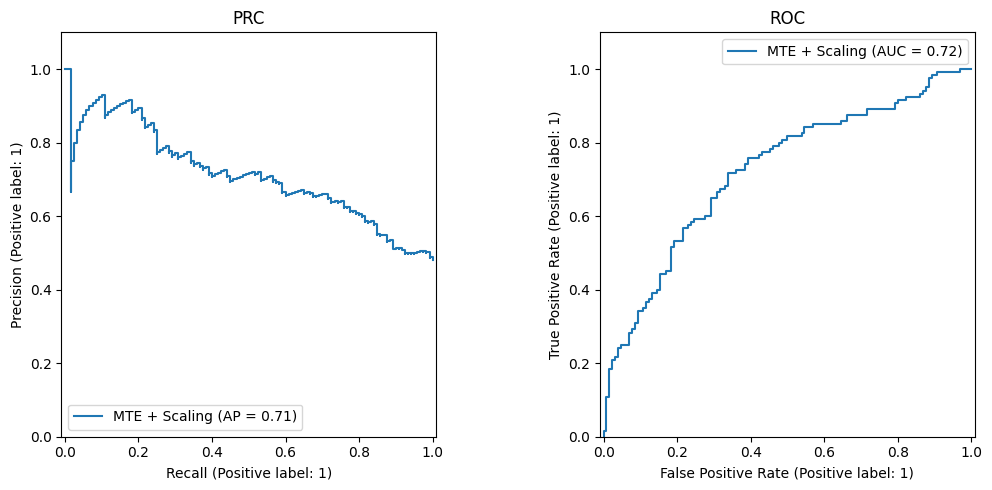

In [23]:
start = time()

pipeline.fit(X_train, y_train)

end = time()
preds = pipeline.predict_proba(X_test)[:, 1]
score = average_precision_score(y_test, preds)

print("Оптимальный C:", best_C)
print("Время (с кодированием):", round(end - start, 2), "сек")
depict_pr_roc(y_test, preds, 'MTE + Scaling')

#### Для Mean Target Encoding + Standard Scaling:
-  **Преимущества**:
  - Сохраняет информацию о взаимосвязи категорий с целевой переменной
  - Не увеличивает размерность пространства признаков
  - Может лучше работать с категориями, имеющими четкую связь с таргетом

-  **Недостатки**:
  - Риск data leakage (нужна аккуратная реализация)
  - Может переобучаться на редких категориях (решается сглаживанием счетчиков)


Время кодирования и обучения: 0.02 сек
OHE + Scaling metrics
AUC-PR: 0.7206
AUC-ROC: 0.7168


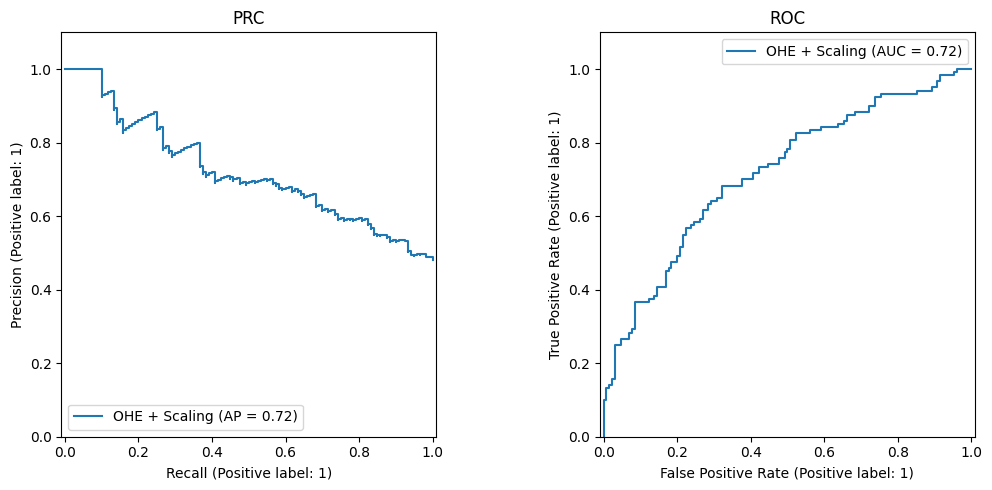

In [24]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
    ('num', StandardScaler(), numerical_columns)
])


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l2', max_iter=1000))
])

start = time()

model = pipeline.fit(X_train, y_train)

duration_ = time() - start
y_pred = model.predict_proba(X_test)[:, 1]

print("Время кодирования и обучения: %.2f сек" % duration)
depict_pr_roc(y_test, y_pred, 'OHE + Scaling')

#### Для One-Hot Encoding + Standard Scaling:
-  **Преимущества**:
  - Полностью сохраняет категориальную информацию без искажений
  - Проще в реализации и интерпретации
  - Нет риска переобучения на редких категориях (при правильной регуляризации)

-  **Недостатки**:
  - Значительно увеличивает размерность данных
  - Может терять информацию о взаимосвязи категорий с таргетом
  - Плохо масштабируется для признаков с большим количеством уникальных значений

## Итоговые выводы по сравнению методов кодирования

### Основные заключения

1. **Эквивалентность методов на малых данных**  
   На небольшой выборке оба метода демонстрируют схожее качество:
   - Разница в метриках (AUC-ROC/PR) можно считать незначительной

2. **Ключевые преимущества Mean Target Encoding**  
   - Сохраняет размерность пространства признаков
   - Позволяет тонко регулировать силу сглаживания через параметр C
   - Лучше работает с категориями, имеющими четкую связь с целевой переменной

3. **Преимущества One-Hot Encoding**  
   - Проще в реализации и интерпретации
   - Не требует специальной защиты от data leakage
   - Более устойчив при наличии редких категорий

### Рекомендации по выбору метода

| Критерий               | Mean Target Encoding | One-Hot Encoding |
|------------------------|----------------------|------------------|
| Маленький датасет      | ➖/➕               | ➕              |
| Большое кол-во категорий| ➕                  | ➖              |
| Сильная связь с таргетом| ➕                  | ➖              |
| Простота реализации    | ➖                  | ➕              |
| Интерпретируемость     | ➖                  | ➕              |

### Практические рекомендации
1. Для **экспериментов и быстрого прототипирования** лучше использовать One-Hot Encoding
2. Для **финальных моделей** на данных с явной зависимостью категорий от таргета - Mean Target Encoding
3. При работе с **очень маленькими выборками** (n < 1000) предпочтительнее One-Hot Encoding с регуляризацией


# Часть 3 Отбор признаков

## Работа с UCI Adult Dataset

### Описание задачи
Мы будем анализировать [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult), который содержит демографические данные и информацию о занятости. Наша цель - предсказать, превышает ли годовой доход человека $50K (бинарная классификация).



In [25]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2025-07-19 13:36:55--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных
Сохранение в: ‘adult.data’

adult.data              [            <=>     ]   3,79M  1,47MB/s    за 2,6s    

2025-07-19 13:36:59 (1,47 MB/s) - ‘adult.data’ сохранён [3974305]



In [26]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

## Отбор признаков и разделение выборки

На практике модель машинного обучения часто обучается на большом количестве признаков, однако не все из них полезны. Некоторые из признаков могут быть шумовыми или избыточными, а их включение в модель может лишь ухудшать её обобщающую способность и увеличивать время обучения. В связи с этим ключевой задачей является **отбор признаков** — поиск подмножества признаков, наиболее информативного для обучения модели.

Перед тем как приступить к методам отбора признаков, разделим имеющуюся выборку на обучающую и тестовую части, в отношении 3 : 1

Разбиение проводится стратифицированно по целевой переменной $y$ с фиксированным генератором случайных чисел (`random_state = 777`), чтобы сохранить пропорции классов и обеспечить воспроизводимость эксперимента.


In [27]:
X = df.drop(columns='income')
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=777,
    stratify=y
)

## One-hot кодирование категориальных признаков

Для категориальных признаков мы будем использовать **one-hot кодирование**. Пусть категориальный признак $x^{(j)}$ принимает $k_j$ различных значений. Тогда после one-hot кодирования этот признак будет представлен в виде $k_j$ бинарных индикаторов, каждый из которых указывает на принадлежность к одному из возможных классов.


In [28]:
categorical = X_train.select_dtypes(include='object').columns
numeric = X_train.select_dtypes(exclude='object').columns

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(X_train[categorical])

print(len(categorical), encoder.transform(X_train[categorical]).shape[1])

8 102


После кодирования категориальных признаков получили $\boxed{94}$ новых признаков.


Логистическая регрессия (базовая) metrics
AUC-PR: 0.7672
AUC-ROC: 0.9070


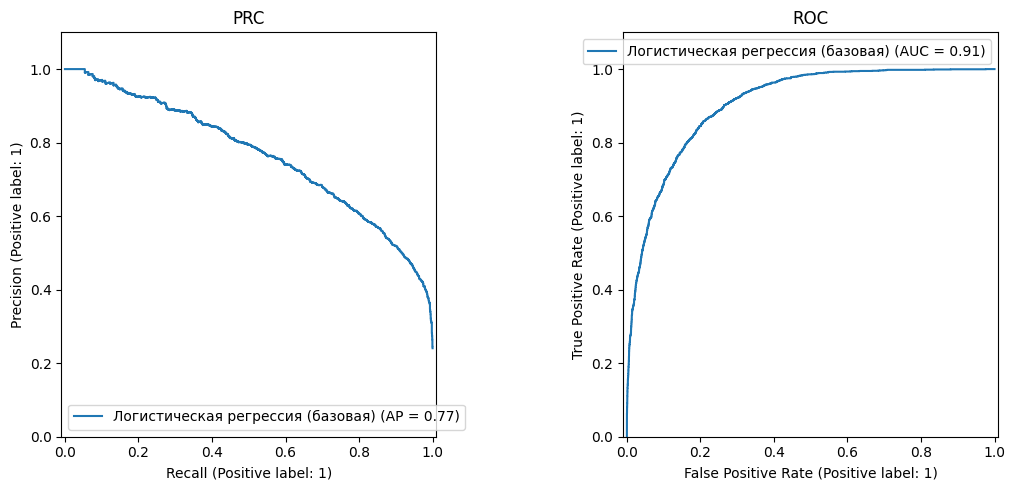

In [29]:
from sklearn.pipeline import make_pipeline

column_transformer_cat = ColumnTransformer([
    ('num', StandardScaler(), numeric),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
])

pipeline = make_pipeline(
    column_transformer_cat,
    LogisticRegression(max_iter=1000)
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict_proba(X_test)[:, 1]

depict_pr_roc(y_test, y_pred, 'Логистическая регрессия (базовая)')

Таким образом мы получили, значение метрики AUC-PR и AUC-ROC для базовой модели логистической регрессии


## Встроенный метод отбора признаков (embedded method)

Разобьём обучающую выборку на подмножества для обучения и валидации. Затем обучим логистическую регрессию и отберём 40 признаков с наибольшим по модулю весом. 


In [30]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=777, stratify=y_train
)

Время подбора признаков: 0.60 сек
Embedded method (Top-40 по весам LR) metrics
AUC-PR: 0.7317
AUC-ROC: 0.8927


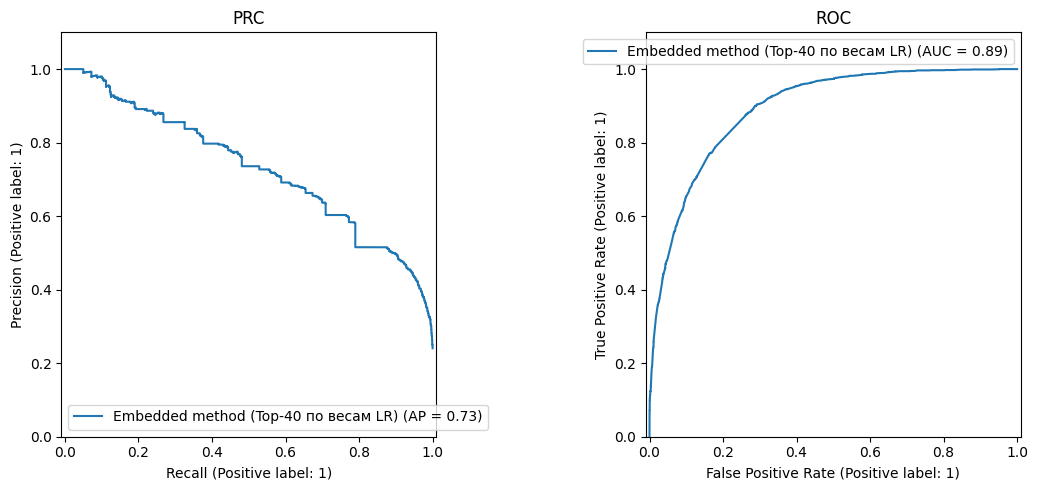

In [31]:
from sklearn.feature_selection import SelectFromModel
import time

start = time.time()

selector = SelectFromModel(
    LogisticRegression(max_iter=1000, penalty='l2'),
    max_features=40,
    prefit=False
)

pipeline = Pipeline([
    ('preprocess', column_transformer_cat),
    ('select', selector),
    ('clf', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train_sub, y_train_sub)

pipeline.named_steps['select'].fit(pipeline.named_steps['preprocess'].transform(X_train_sub), y_train_sub)

X_train_sel = pipeline.named_steps['select'].transform(pipeline.named_steps['preprocess'].transform(X_train))
X_test_sel = pipeline.named_steps['select'].transform(pipeline.named_steps['preprocess'].transform(X_test))

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_sel, y_train)

y_pred = clf.predict_proba(X_test_sel)[:, 1]

duration = time.time() - start
print("Время подбора признаков: %.2f сек" % duration)
depict_pr_roc(y_test, y_pred, 'Embedded method (Top-40 по весам LR)')

Метрика AUC-PR для модели с 40 признаками, отобранными встроенным методом, составляет 0.7317. Время отбора и переобучения: 0.66 секунд.


## Отбор признаков с помощью корреляции (filter method)

Переходим к методам фильтрации. Одним из самых простых и распространённых подходов является использование корреляции между отдельным признаком и целевой переменной.

Корреляция измеряет степень линейной зависимости между двумя переменными. В контексте классификации, особенно с бинарной целевой переменной, это даёт грубое приближение к предсказательной способности признака: чем выше модуль корреляции с целевой переменной, тем полезнее признак.

Мы будем использовать абсолютное значение корреляции, чтобы учитывать признаки, как положительно, так и отрицательно связанные с таргетом.


In [32]:
X_train_enc = pd.get_dummies(X_train)
X_test_enc = pd.get_dummies(X_test)
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_enc), columns=X_train_enc.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_enc), columns=X_test_enc.columns)

Correlation filter (Top 40) metrics
AUC-PR: 0.6490
AUC-ROC: 0.8625


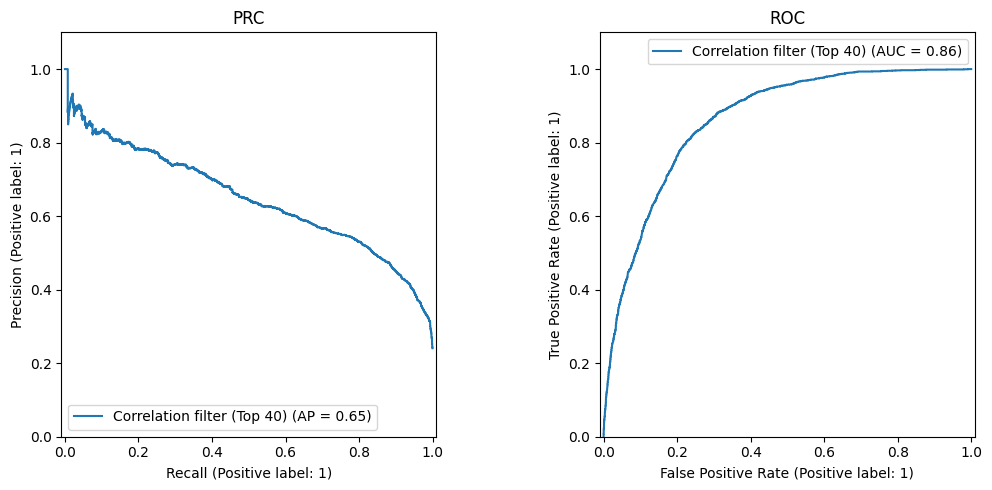

In [33]:
corrs = X_train_scaled.corrwith(y_train).abs()
top40_corr = corrs.sort_values(ascending=False).head(40).index

clf = LogisticRegression(max_iter=5000)
clf.fit(X_train_scaled[top40_corr], y_train)
y_pred_corr = clf.predict_proba(X_test_scaled[top40_corr])[:, 1]

depict_pr_roc(y_test, y_pred_corr, 'Correlation filter (Top 40)')

#### Фильтрация по t-статистике

Теперь в качестве меры значимости признаков воспользуемся t-статистикой:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ — среднее, дисперсия и число объектов каждого класса соответственно.

Сравним 40 наиболее значимых признаков по этой метрике.

T-statistic filter (Top 40) metrics
AUC-PR: 0.6490
AUC-ROC: 0.8625


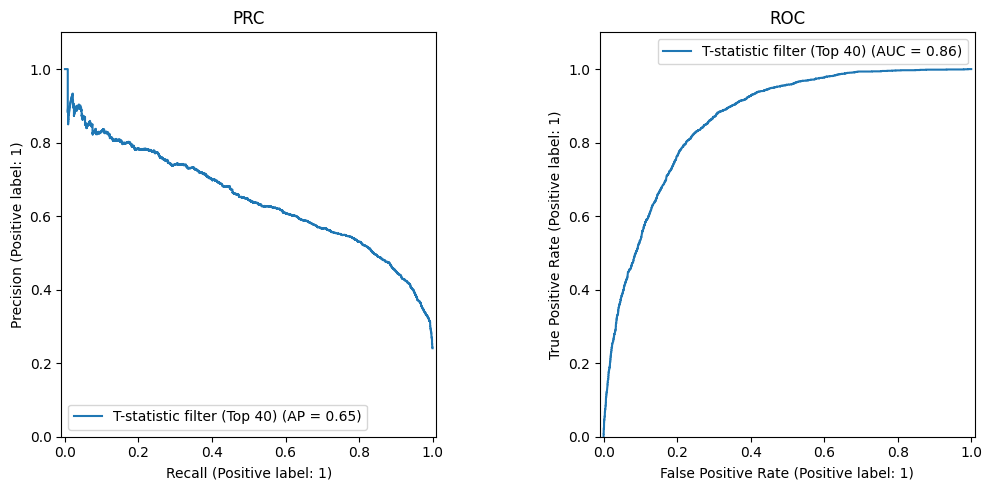

In [34]:
y_train_series = pd.Series(y_train, index=X_train_scaled.index)

X_pos = X_train_scaled[y_train_series == 1]
X_neg = X_train_scaled[y_train_series == 0]

mu_pos = X_pos.mean()
mu_neg = X_neg.mean()
std_pos = X_pos.std(ddof=1)
std_neg = X_neg.std(ddof=1)

n_pos = len(X_pos)
n_neg = len(X_neg)

t_stat = ((mu_pos - mu_neg).abs()) / np.sqrt((n_pos * std_pos**2 + n_neg * std_neg**2) / (n_pos + n_neg))
top40_t = t_stat.sort_values(ascending=False).head(40).index

clf = LogisticRegression(max_iter=5000)
clf.fit(X_train_scaled[top40_t], y_train)
y_pred_t = clf.predict_proba(X_test_scaled[top40_t])[:, 1]

depict_pr_roc(y_test, y_pred_t, 'T-statistic filter (Top 40)')


#### __Сравнение отобранных признаков__

Посмотрим, насколько сильно пересекаются признаки, выбранные с помощью корреляции и $t$-статистики.


In [35]:
set_corr = set(top40_corr)
set_t = set(top40_t)

len(set_corr.intersection(set_t))


40

###  Методы-обёртки (Wrapper Methods)

Мы реализуем метод отбора признаков с помощью жадного исключения (feature elimination).

Идея состоит в следующем:

- На каждой итерации обучаем модель на текущем подмножестве признаков.
- Удаляем $m$ наименее важных признаков (по модулю коэффициентов логистической регрессии).
- Повторяем, пока не останется $k$ признаков.

**Параметры:**

- Целевое количество признаков: $k = 40$
- Длина шага: $m = 10$  
  Выбрана как разумный компромисс между числом итераций и грубостью отбора. Уменьшение $m$ ведёт к увеличению времени, увеличение — к риску выкинуть полезные признаки.


In [36]:
X_fs = pd.get_dummies(X_train)
X_test_fs = pd.get_dummies(X_test)

X_fs, X_test_fs = X_fs.align(X_test_fs, join='left', axis=1, fill_value=0)

scaler = StandardScaler()
X_fs = pd.DataFrame(scaler.fit_transform(X_fs), columns=X_fs.columns, index=X_fs.index)
X_test_fs = pd.DataFrame(scaler.transform(X_test_fs), columns=X_test_fs.columns, index=X_test_fs.index)

Wrapper method (greedy) with StandardScaler metrics
AUC-PR: 0.7646
AUC-ROC: 0.9056
Отобрано признаков: 40
Время: 9.93 сек


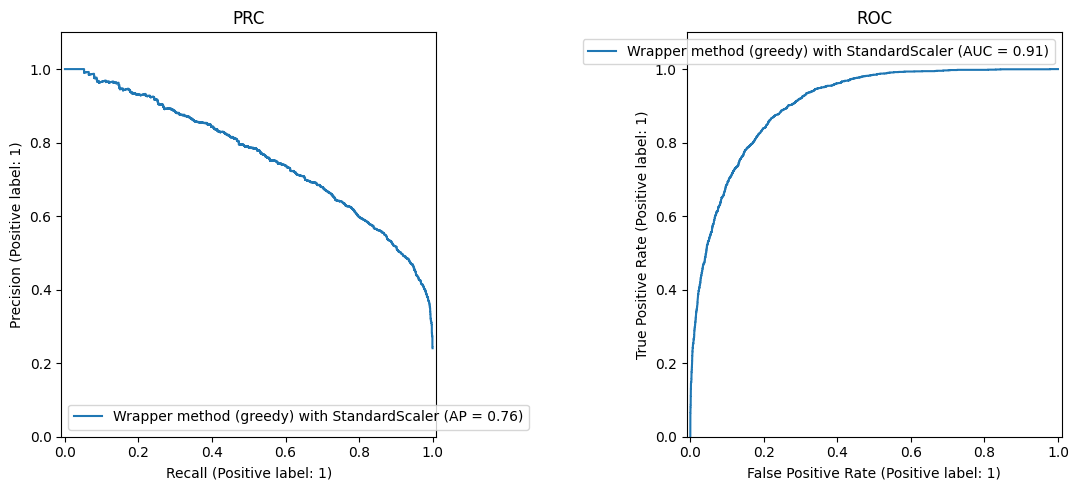

In [37]:
k = 40
m = 10

features = list(X_fs.columns)
history = []

start = time.time()

while len(features) > k:
    clf = LogisticRegression(max_iter=3000)
    clf.fit(X_fs[features], y_train)
    
    importance = np.abs(clf.coef_[0])
    feature_importance = pd.Series(importance, index=features)
    
    least_important = feature_importance.sort_values().head(min(m, len(features) - k)).index
    features = [f for f in features if f not in least_important]

    clf = LogisticRegression(max_iter=3000)
    clf.fit(X_fs[features], y_train)
    score = clf.score(X_fs[features], y_train)

    history.append((len(features), score))

end = time.time()

X_train_wrap = X_fs[features]
X_test_wrap = X_test_fs[features]

clf = LogisticRegression(max_iter=3000)
clf.fit(X_train_wrap, y_train)
y_pred_wrap = clf.predict_proba(X_test_wrap)[:, 1]

depict_pr_roc(y_test, y_pred_wrap, 'Wrapper method (greedy) with StandardScaler')

print("Отобрано признаков:", len(features))
print("Время:", round(end - start, 2), "сек")

## Калибровка вероятностей: изотоническая регрессия и калибровка Платта

Построенные нами классификаторы, такие как логистическая регрессия, обучаются минимизировать определённую функцию потерь (например, логарифмическую). Однако предсказываемые ими вероятности не всегда являются *калиброванными*, то есть не всегда интерпретируются как истинная вероятность наступления события. Например, если модель предсказывает вероятность класса 1 равной 0.9, то в калиброванной модели примерно 90% таких наблюдений действительно должны принадлежать к классу 1. На практике это часто не выполняется.

Чтобы скорректировать вероятностные оценки модели и привести их к интерпретируемому виду, применяются методы **калибровки вероятностей**.

---

### Математическая постановка задачи

Пусть $f: \mathbb{R}^d \to [0, 1]$ — модель, предсказывающая вероятность класса 1. Мы хотим найти функцию $g: [0, 1] \to [0, 1]$, такую что $g \circ f$ будет хорошо приближать истинную вероятность:

$
\mathbb{P}(y = 1 \mid x) \approx g(f(x))
$

Калибровка осуществляется по отложенной выборке (валидационной), не участвующей в обучении $f$.

---

### Используемые методы

#### 1. Изотоническая регрессия
Метод нелинейной калибровки, предполагающий, что вероятность является **монотонной** функцией от выхода модели. Это наиболее гибкий подход, не предполагающий формы калибровочной функции. Мы находим $g$ в виде кусочно-постоянной монотонной функции, минимизируя эмпирическую ошибку на валидационной выборке.

#### 2. Калибровка Платта
Это параметрическая модель: применяется логистическая регрессия поверх выхода классификатора:

$
g(z) = \frac{1}{1 + \exp(Az + B)}
$

где параметры $A, B$ подбираются по валидационным данным методом максимального правдоподобия. Этот метод устойчив, но менее гибкий, чем изотоническая регрессия.

---

### Практическое применение

Для обучения калибровочной функции мы используем объект `CalibratedClassifierCV` из `sklearn`. Он позволяет откалибровать уже обученную модель по отложенной выборке двумя способами: `"isotonic"` и `"sigmoid"` (Платт).

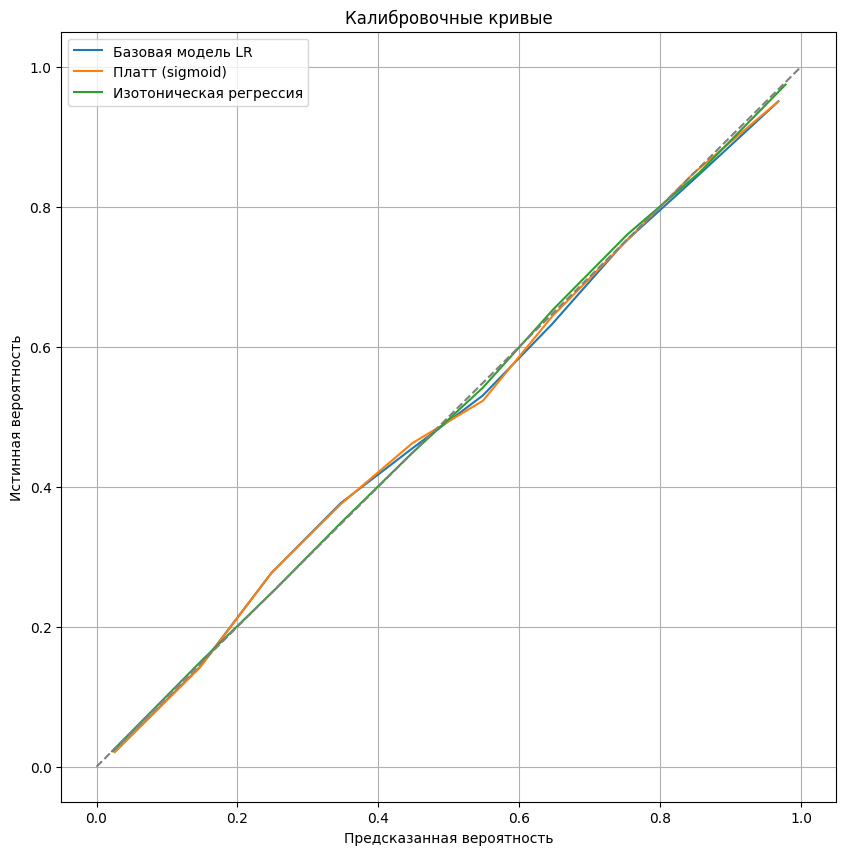

Brier (исходная LR): 0.10189535331047685
Brier (Платт): 0.10188898374985816
Brier (Изотоническая): 0.10144718188324879


In [38]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss

base_model = LogisticRegression(max_iter=2000)
base_model.fit(X_train_wrap, y_train)

model_sigmoid = CalibratedClassifierCV(base_model, method='sigmoid', cv=5)
model_sigmoid.fit(X_train_wrap, y_train)

model_iso = CalibratedClassifierCV(base_model, method='isotonic', cv=5)
model_iso.fit(X_train_wrap, y_train)

probs_basic = base_model.predict_proba(X_train_wrap)[:, 1]
probs_sigmoid = model_sigmoid.predict_proba(X_train_wrap)[:, 1]
probs_iso = model_iso.predict_proba(X_train_wrap)[:, 1]

true_prob_basic, pred_basic = calibration_curve(y_train, probs_basic, n_bins=10)
true_prob_sigmoid, pred_sigmoid = calibration_curve(y_train, probs_sigmoid, n_bins=10)
true_prob_iso, pred_iso = calibration_curve(y_train, probs_iso, n_bins=10)

plt.figure(figsize=(10,10))
plt.plot(pred_basic, true_prob_basic, label='Базовая модель LR',)
plt.plot(pred_sigmoid, true_prob_sigmoid, label='Платт (sigmoid)')
plt.plot(pred_iso, true_prob_iso, label='Изотоническая регрессия')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("Предсказанная вероятность")
plt.ylabel("Истинная вероятность")
plt.title("Калибровочные кривые")
plt.legend()
plt.grid()
plt.show()

print("Brier (исходная LR):", brier_score_loss(y_train, probs_basic))
print("Brier (Платт):", brier_score_loss(y_train, probs_sigmoid))
print("Brier (Изотоническая):", brier_score_loss(y_train, probs_iso))

данная процедура особа важна для таких моделей как SVC, которые страдают переуверенностью, ниже пример на данных небольшой размерности ~20000

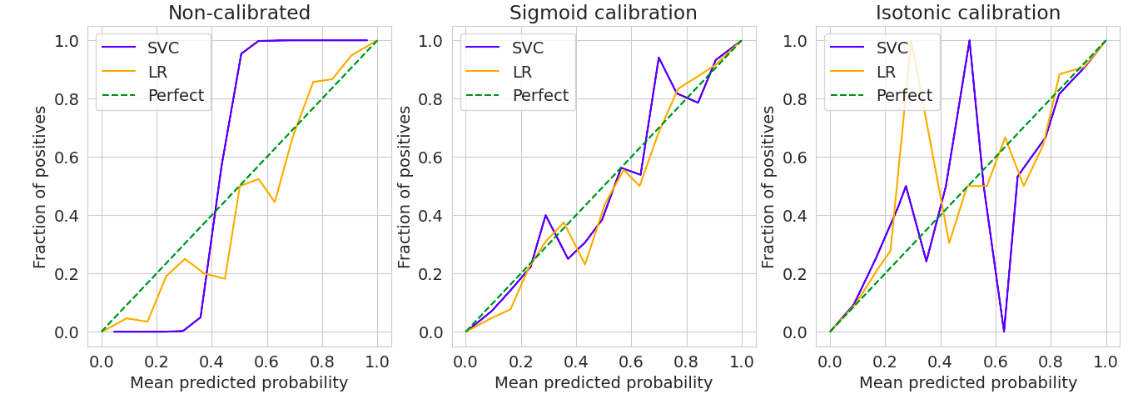

### Вывод

- Калибровка позволяет улучшить интерпретируемость вероятностей.
- Изотоническая калибровка точнее, но может переобучаться при малом числе наблюдений.
- Калибровка Платта более устойчива, но менее гибка.
- Метрика `Brier score` после калибровки показывает, насколько близки предсказания к истинным вероятностям.


# Часть 4. Прогноз по доходам и расходам

На данном этапе мы приступаем к анализу датасета, отражающего результаты телефонного маркетинга банковских услуг — [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing).

Объектом нашего анализа является телефонный звонок потенциальному клиенту с предложением банковского депозита. Каждому звонку сопоставляется вектор признаков, включающий:

- личные характеристики клиента (образование, семейное положение, работа и т.д.),
- параметры самого звонка (месяц, день недели, продолжительность — которая, однако, исключается из анализа как утечка),
- экономические показатели (уровень безработицы, процентная ставка, уверенность потребителей и пр.).

Целевой переменной служит бинарный индикатор: дал ли клиент согласие на размещение депозита (`y == "yes"`).


In [39]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip

--2025-07-19 13:37:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных
Сохранение в: ‘bank-additional.zip’

bank-additional.zip     [     <=>            ] 434,15K   450KB/s    за 1,0s    

2025-07-19 13:37:29 (450 KB/s) - ‘bank-additional.zip’ сохранён [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional 

In [40]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes') 

#### Кросс-валидация

В этом разделе мы откажемся от выделения фиксированной тестовой выборки, применяя вместо этого **стратифицированную кросс-валидацию** — более универсальный и надёжный способ оценки качества модели. Мы будем делить исходное множество объектов на несколько частей (фолдов), обучаться на всех кроме одной и валидироваться на оставшейся.

Для этого используем `StratifiedKFold` из `sklearn.model_selection`. В качестве параметров выбраны:

- `n_splits = 5` — стандартное число фолдов, обеспечивающее баланс между смещением и дисперсией оценки;
- `shuffle = True` — для перемешивания индексов перед делением (при работе с временными или упорядоченными данными это важно);
- `random_state = 42` — для воспроизводимости.


In [41]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

import pandas as pd

def cross_validate(
    X, y, n_splits=5, random_state=42, shuffle=True
):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    categorical = X.select_dtypes(include="object").columns.tolist()
    numerical = X.select_dtypes(include="number").columns.tolist()

    preprocessor = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", StandardScaler(), numerical),
    ])

    pipeline = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

    metrics = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        profit = ((y_pred == 1) * (-2 + 10 * y_test)).sum()
        
        metrics.append({
            "accuracy": accuracy_score(y_test, y_pred),
            "average_precision": average_precision_score(y_test, y_proba),
            "roc_auc": roc_auc_score(y_test, y_proba),
            "profit": profit
        })

    return pd.DataFrame(metrics)

In [42]:
results_logreg = cross_validate(X, y)
results_logreg

,accuracy,average_precision,roc_auc,profit
0,0.896091,0.434724,0.788571,1188
1,0.900825,0.434034,0.785290,1488
2,0.905317,0.484694,0.804458,1844
3,0.899478,0.446875,0.787580,1496
4,0.898871,0.459337,0.791915,1408


####  Математическая модель прибыли

Обозначим через $X \in \mathbb{R}^d$ признаки клиента, через $y \in \{0, 1\}$ — целевую переменную:
- $y = 1$, если клиент согласился на депозит;
- $y = 0$, если отказался.

Пусть бинарный классификатор выдаёт для каждого объекта $x_i$ вероятность $\hat{p}_i = \mathbb{P}(y_i = 1 \mid x_i)$.

Мы считаем, что **звонки совершаются всем объектам с $\hat{p}_i \geq t$**, где $t$ — фиксированный порог (в нашем случае мы используем `predict_proba` и порог $t = 0.5$ по умолчанию).

##### Бизнес-прибыль:
- __Доход__: если $y_i = 1$, банк зарабатывает **$+10$ долларов**.
- __Расход__: за каждый звонок оператору платят **$-2$ доллара**, независимо от ответа.

Таким образом, **прибыль на одном объекте** равна:
$$
\text{profit}_i =
\begin{cases}
10 - 2 = 8, & \text{если } \hat{y}_i = 1 \text{ и } y_i = 1 \\
-2, & \text{если } \hat{y}_i = 1 \text{ и } y_i = 0 \\
0, & \text{если } \hat{y}_i = 0
\end{cases}
$$

Общая прибыль вычисляется как:

$$
\text{Profit} = \sum_{i=1}^n \left[ 
\mathbb{I}(\hat{y}_i = 1) \cdot \left( 
\mathbb{I}(y_i = 1) \cdot 8 - \mathbb{I}(y_i = 0) \cdot 2 
\right) 
\right]
$$

Где:
- $\mathbb{I}(\hat{y}_i = 1)$ — индикатор звонка клиенту,
- $\mathbb{I}(y_i = 1)$ — индикатор согласия на депозит,
- $\mathbb{I}(y_i = 0)$ — индикатор отказа.


Теперь внесём некоторую долю случайности в модель прибыли.

Если клиент **согласился** на депозит ($y_i = 1$), он приносит случайную выручку $R_i \sim \text{Uniform}[0, 20)$. При этом звонок по-прежнему стоит фиксированно $2.

---

**Прибыль на одном клиенте:**

$$
\text{profit}_i =
\begin{cases}
R_i - 2, & \text{если } \hat{y}_i = 1 \text{ и } y_i = 1 \\
-2, & \text{если } \hat{y}_i = 1 \text{ и } y_i = 0 \\
0, & \text{если } \hat{y}_i = 0
\end{cases}
$$

---

**Общая прибыль по выборке:**

$$
\text{Profit} = \sum_{i=1}^n \left[ \mathbb{I}(\hat{y}_i = 1) \cdot \left( \mathbb{I}(y_i = 1) \cdot R_i - 2 \right) \right],
$$

где $R_i \sim \text{Uniform}[0, 20)$ только для клиентов с $y_i = 1$.


## Математическое ожидание прибыли со случайной выручкой

Рассмотрим:
$$
X_i = \mathbb{I}(\hat{y}_i = 1) \cdot \left( \mathbb{I}(y_i = 1) \cdot R_i - 2 \right)
$$

Условное матожидание при $y_i = 1$

Если $y_i = 1$, то $R_i \sim \text{Uniform}[0, 20)$, и

$$
\mathbb{E}[R_i \mid y_i = 1] = 10
$$

Следовательно:

$$
\mathbb{E}[X_i \mid y_i = 1] = \mathbb{P}(\hat{y}_i = 1 \mid y_i = 1) \cdot (10 - 2) = 8 \cdot \text{TPR}
$$

Условное матожидание при $y_i = 0$

$$
\mathbb{E}[X_i \mid y_i = 0] = \mathbb{P}(\hat{y}_i = 1 \mid y_i = 0) \cdot (-2) = -2 \cdot \text{FPR}
$$

Ожидаемая прибыль модели выражается как:

$$
\mathbb{E}[\text{Profit}] = n \cdot \left( 8 \cdot \mathbb{P}(\hat{y}_i = 1 \mid y_i = 1) \cdot p - 2 \cdot \mathbb{P}(\hat{y}_i = 1 \mid y_i = 0) \cdot (1 - p) \right)
$$

Где:

- $n$ — общее количество наблюдений,
- $p = \mathbb{P}(y_i = 1)$ — вероятность положительного класса,
- $\text{TPR} = \mathbb{P}(\hat{y}_i = 1 \mid y_i = 1)$ — доля верно предсказанных положительных примеров (True Positive Rate),
- $\text{FPR} = \mathbb{P}(\hat{y}_i = 1 \mid y_i = 0)$ — доля ложно предсказанных положительных примеров (False Positive Rate).


In [43]:
def profit_with_random_gain(y_true, y_pred):
    calls = y_pred == 1
    gains = np.zeros_like(y_true, dtype=float)
    accepted = (y_true == 1) & calls
    gains[accepted] = np.random.uniform(0, 20, size=accepted.sum())
    losses = calls.astype(int) * 2
    return (gains - losses).sum()

def cross_validate_with_profit(
    X, y, n_splits=5, random_state=42, shuffle=True
):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    categorical = X.select_dtypes('object').columns.tolist()
    numerical = X.select_dtypes('number').columns.tolist()

    preprocessor = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical),
        ("num", StandardScaler(), numerical)
    ])

    pipeline = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

    metrics = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipeline.fit(X_train, y_train)
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        y_pred = pipeline.predict(X_test)

        profit = profit_with_random_gain(y_test.values, y_pred)

        metrics.append({
            "accuracy": accuracy_score(y_test, y_pred),
            "average_precision": average_precision_score(y_test, y_proba),
            "roc_auc": roc_auc_score(y_test, y_proba),
            "profit": profit,
        })

    
    return pd.DataFrame(metrics)


In [44]:
results_random_profit = cross_validate_with_profit(X, y)
results_random_profit


,accuracy,average_precision,roc_auc,profit
0,0.896091,0.434724,0.788571,1244.644966
1,0.900825,0.434034,0.785290,1561.278869
2,0.905317,0.484694,0.804458,1944.165084
3,0.899478,0.446875,0.787580,1472.927618
4,0.898871,0.459337,0.791915,1392.976735


In [45]:
mean_profit = results_random_profit['profit'].mean()
std_profit = results_random_profit['profit'].std()
operator_costs = 2 * (results_random_profit['profit'] + 2 * (y.shape[0] / 5)).mean()  # оценка сверху
correlation = results_random_profit.corr().loc["profit", "average_precision"]

print("Средняя прибыль: ", mean_profit)
print("Стандартное отклонение прибыли: ", std_profit)
print("Оценка выплат операторам: ", operator_costs)
print("Корреляция бизнес-метрики и average_precision: ", correlation)


Средняя прибыль:  1523.1986542481363
Стандартное отклонение прибыли:  262.5547179917478
Оценка выплат операторам:  35996.79730849627
Корреляция бизнес-метрики и average_precision:  0.7782164429748054


100%|███████████████████████████████████████████| 30/30 [02:09<00:00,  4.33s/it]


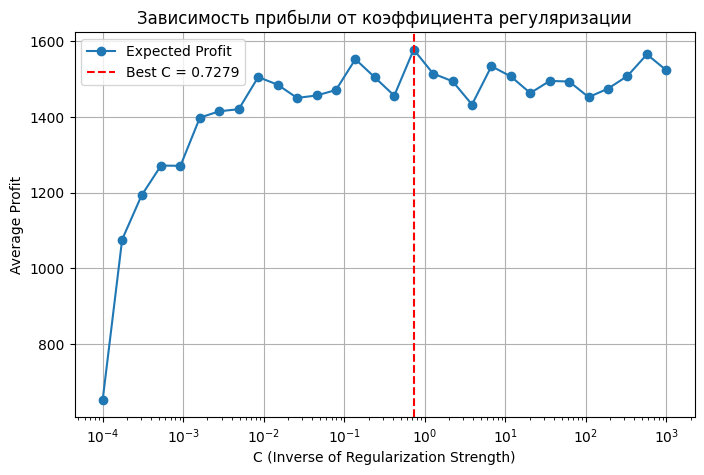

In [46]:
from tqdm import tqdm

X = pd.get_dummies(X)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

alphas = np.logspace(-4, 3, 30)
profit_results = []
average_precision_results = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for C in tqdm(alphas):
    profits = []
    average_precisions = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = LogisticRegression(C=C, max_iter=1000)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        revenue = np.where(
            y_pred == 1,
            np.where(y_test == 1, np.random.uniform(0, 20, size=len(y_test)), 0),
            0,
        )
        cost = np.where(y_pred == 1, 2, 0)
        profit = revenue.sum() - cost.sum()
        profits.append(profit)

        pr_auc = average_precision_score(y_test, y_proba)
        average_precisions.append(pr_auc)

    profit_results.append(np.mean(profits))
    average_precision_results.append(np.mean(average_precisions))

profit_results = np.array(profit_results)
average_precision_results = np.array(average_precision_results)

best_idx = np.argmax(profit_results)
best_C = alphas[best_idx]
best_profit = profit_results[best_idx]

plt.figure(figsize=(8, 5))
plt.plot(alphas, profit_results, marker='o', label='Expected Profit')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Average Profit')
plt.title('Зависимость прибыли от коэффициента регуляризации')
plt.axvline(best_C, color='r', linestyle='--', label=f'Best C = {best_C:.4f}')
plt.legend()
plt.grid(True)
plt.show()


Для нашего бизнеса важнее **precision**, то есть доля правильно предсказанных положительных исходов среди всех предсказанных положительных. Это связано с тем, что **каждый звонок операторов стоит 2 доллара**, и мы тратим деньги каждый раз, когда модель предсказывает класс `1`, независимо от того, оказался ли клиент согласным или нет.

Если модель ошибается (ложноположительный результат), мы тратим деньги впустую — клиент не соглашается, но звонок уже совершен и оплачен. Таким образом, **чем выше precision, тем выше вероятность, что потраченные средства действительно окупятся**, и звонок принесёт прибыль.

В то же время, низкий recall — то есть упущенные согласные клиенты — тоже приводит к недополученной выручке, но **не влечёт прямых расходов**, поэтому для минимизации убытков **precision критичнее**.

---

#### __Исследование порога бинаризации для логистической регрессии__

Напомним, что логистическая регрессия выдаёт не бинарный прогноз, а вероятность положительного исхода. Принято использовать порог $0.5$ для перевода вероятности в метку класса, однако это значение не всегда оптимально для задач, где важно учитывать стоимость ошибок.

Поскольку в нашей задаче важна прибыль, разумно попробовать найти такой **порог бинаризации**, при котором суммарная прибыль максимальна. Мы будем перебирать значения порога от $0.00$ до $1.00$ с шагом $0.1$ по кросс-валидации.

Также нас интересует, существует ли корреляция между новой ML-метрикой (например, average precision) и итоговой прибылью.


In [47]:
thresholds = np.linspace(0, 1, 10)
profit_per_threshold = []
average_precision_per_threshold = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for threshold in tqdm(thresholds):
    profits = []
    average_precisions = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)

        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= threshold).astype(int)

        revenue = np.where(
            y_pred == 1,
            np.where(y_test == 1, np.random.uniform(0, 20, size=len(y_test)), 0),
            0,
        )
        cost = np.where(y_pred == 1, 2, 0)
        profit = revenue.sum() - cost.sum()
        profits.append(profit)

        pr_auc = average_precision_score(y_test, y_proba)
        average_precisions.append(pr_auc)

    profit_per_threshold.append(np.mean(profits))
    average_precision_per_threshold.append(np.mean(average_precisions))


100%|███████████████████████████████████████████| 10/10 [00:56<00:00,  5.67s/it]


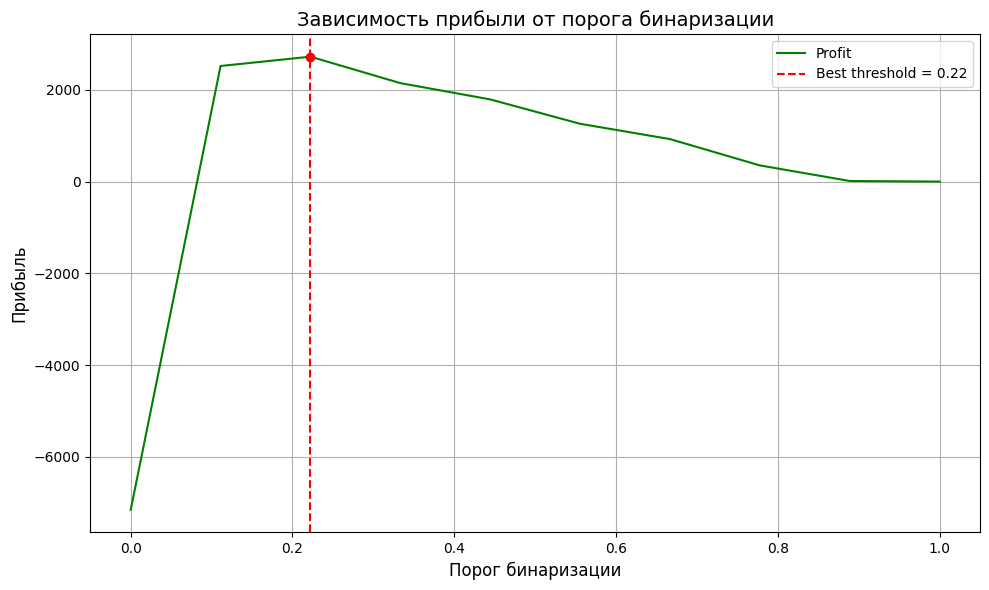

In [48]:
best_idx = np.argmax(profit_per_threshold)
best_threshold = thresholds[best_idx]
best_profit = profit_per_threshold[best_idx]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, profit_per_threshold, label='Profit', color='green')
plt.axvline(x=best_threshold, linestyle='--', color='red', label=f'Best threshold = {best_threshold:.2f}')
plt.scatter([best_threshold], [best_profit], color='red', zorder=5)
plt.title('Зависимость прибыли от порога бинаризации', fontsize=14)
plt.xlabel('Порог бинаризации', fontsize=12)
plt.ylabel('Прибыль', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### __Замечание о закономерности порога__

Мы заметили, что оптимальный порог бинаризации по прибыли стабильно оказывается около **0.2**, что значительно ниже стандартного значения $0.5$.

Это объясняется экономической моделью задачи. Мы совершаем звонок клиенту, если ожидаемая прибыль от этого действия положительна. Пусть $p$ — вероятность согласия клиента, тогда ожидаемая прибыль:

$$
\mathbb{E}[\text{прибыль}] = p \cdot \text{доход} - \text{расход}
$$

В нашем случае доход составляет в среднем $10$, расход — $2$, отсюда порог:

$$
p \cdot 10 - 2 > 0 \Rightarrow p > 0.2
$$

Таким образом, **порог около 0.2 — это оптимальное значение**, при котором совершение звонка клиенту становится экономически оправданным. Это и объясняет устойчивость этого значения при повторных запусках эксперимента.


#### Сравнение дефолтной и оптимизированной логистической регрессии по прибыли

Чтобы убедиться, что наша оптимизация модели (по гиперпараметру $C$ и порогу бинаризации) действительно улучшила бизнес-показатель — ожидаемую прибыль, мы сравним результаты на кросс-валидации и применим статистический критерий.

Мы рассмотрели две модели:

- **Базовая логистическая регрессия** с параметрами по умолчанию и порогом $0.5$
- **Оптимизированная модель**, настроенная по прибыли (включая случайную выручку от клиента) с подобранными $C$ и порогом

В обоих случаях мы посчитали прибыль на каждом из 5 фолдов, а затем применили **парный t-критерий Стьюдента**.

$$
H_0: \text{Средняя прибыль не изменилась} 
$$
$$
H_1: \text{Оптимизация увеличила среднюю прибыль}
$$

Если $p < 0.05$, то мы отвергаем $H_0$ и делаем вывод, что **оптимизация действительно привела к статистически значимому увеличению прибыли**.

Если же $p > 0.05$, то полученные улучшения **могут быть обусловлены случайностью**, и требуется более сложная модель или другой способ оптимизации.


In [49]:
from scipy.stats import ttest_rel

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

default_profits = []
optimized_profits = []

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model_default = LogisticRegression(max_iter=1000)
    model_default.fit(X_train, y_train)
    y_pred_def = model_default.predict(X_test)

    revenue_def = np.where(
        y_pred_def == 1,
        np.where(y_test == 1, np.random.uniform(0, 20, size=len(y_test)), 0),
        0,
    )
    cost_def = np.where(y_pred_def == 1, 2, 0)
    profit_def = revenue_def.sum() - cost_def.sum()
    default_profits.append(profit_def)

    model_opt = LogisticRegression(C=best_C, max_iter=1000)
    model_opt.fit(X_train, y_train)
    y_proba_opt = model_opt.predict_proba(X_test)[:, 1]
    y_pred_opt = (y_proba_opt > best_threshold).astype(int)

    revenue_opt = np.where(
        y_pred_opt == 1,
        np.where(y_test == 1, np.random.uniform(0, 20, size=len(y_test)), 0),
        0,
    )
    cost_opt = np.where(y_pred_opt == 1, 2, 0)
    profit_opt = revenue_opt.sum() - cost_opt.sum()
    optimized_profits.append(profit_opt)

default_mean = np.mean(default_profits)
optimized_mean = np.mean(optimized_profits)
default_std = np.std(default_profits)
optimized_std = np.std(optimized_profits)

t_stat, p_value = ttest_rel(optimized_profits, default_profits)

print(f"Default mean profit:     {default_mean:.2f} ± {default_std:.2f}")
print(f"Optimized mean profit:   {optimized_mean:.2f} ± {optimized_std:.2f}")
print(f"p-value (paired t-test): {p_value:.4f}")


Default mean profit:     1538.94 ± 194.20
Optimized mean profit:   2780.52 ± 165.84
p-value (paired t-test): 0.0001


### Статистическая значимость улучшения модели

Для проверки того, действительно ли оптимизированная модель превосходит дефолтную, мы применили парный t-критерий с уровнем значимости $\alpha = 0.05$.

#### Интерпретация результата

- **Нулевая гипотеза** $H_0$: средняя прибыль от оптимизированной и дефолтной модели одинакова.
- **Альтернативная гипотеза** $H_1$: прибыль отличается.

Мы получили:

- **p-value ≈ 0.0**

#### Вывод

Очень малое значение p-value означает, что наблюдаемое улучшение в прибыли **крайне маловероятно** получено случайно при справедливости $H_0$. То есть мы имеем **статистически значимое** улучшение. Мы отвергаем $H_0$ и заключаем, что:

> **Оптимизация модели (регуляризация + настройка порога) действительно приводит к увеличению прибыли.**

Однако стоит отметить, что p-value не измеряет **величину улучшения**, а лишь говорит о его **надежности**. При больших выборках даже незначительные эффекты могут быть статистически значимы.
